<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Simulate_Sessions_dataset_simulated_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Simulate_Sessions_dataset_simulated_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate TMS-fMRI Sessions with Population ANN

Generate synthetic TMS-fMRI dataset using the population ANN model trained on task-rest data.

**Workflow:**
1. Load empirical dataset and population model
2. Generate synthetic rest + stim sessions for all subjects
3. Validate with subject-specific ΔFC analysis (empirical vs simulated)

In [1]:
# =========================
# SETUP
# =========================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, sys, pickle, json, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Clone repo + add to path
REPO_DIR = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

sys.path.append(REPO_DIR)
from src.NPI import build_model, device
print(f"PyTorch device: {device}")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 582, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 582 (delta 27), reused 14 (delta 14), pack-reused 538 (from 1)
Receiving objects: 100% (582/582), 82.06 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (204/204), done.
PyTorch device: cpu


In [2]:
# =========================
# PATHS
# =========================
BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

DATASET_EMP_PKL = os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl")
PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
MODEL_DIR = os.path.join(PREPROC_ROOT, "trained_models_MLP_tms_fmri")

# Find population model
MODEL_PATH = os.path.join(MODEL_DIR, "population_MLP_tms_fmri.pt")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Population model not found: {MODEL_PATH}")

# Output directory
OUT_DIR = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PKL = os.path.join(OUT_DIR, "dataset_simulated_populationANN.pkl")
RESULTS_JSON = os.path.join(OUT_DIR, "deltafc_validation_results.json")

print(f"✓ Dataset: {DATASET_EMP_PKL}")
print(f"✓ Model: {MODEL_PATH}")
print(f"✓ Output: {OUT_PKL}")

✓ Dataset: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl
✓ Model: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri/population_MLP_tms_fmri.pt
✓ Output: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/dataset_simulated_populationANN.pkl


In [36]:
# =========================
# CONFIG
# =========================
S = 3                          # Window length (steps)
N = 450                        # Number of ROIs
TR_MODEL = 2.0                 # Model TR (seconds)
BURN_IN = 10                   # Burn-in steps
NOISE_SIGMA = 0.05              # Input noise magnitude
STIM_AMP = 5.0                 # Stimulation amplitude
STIM_DURATION_S = 2.0          # TMS pulse duration (seconds)
RHO_MM = 10.0                  # Gaussian spread (mm)
MAP_MODE = "round"             # Onset mapping mode

rng = np.random.default_rng(42)

# Load distance matrix + compute Gaussian kernel
DIST_PATH = os.path.join(BASE, "TMS_fMRI", "atlases", "distance_matrix_450x450_Tian50_Schaefer400.npy")
D = np.load(DIST_PATH)
W = np.exp(-(D ** 2) / (2.0 * (RHO_MM ** 2))).astype(np.float32)
W /= (W[np.arange(N), np.arange(N)][:, None] + 1e-8)  # Normalize so target = 1

print(f"Config: S={S}, N={N}, TR={TR_MODEL}s, noise={NOISE_SIGMA}, stim_amp={STIM_AMP}")
print(f"Distance matrix: {D.min():.1f}-{D.max():.1f} mm | RHO_MM={RHO_MM}")

Config: S=3, N=450, TR=2.0s, noise=0.05, stim_amp=5.0
Distance matrix: 0.0-170.5 mm | RHO_MM=10.0


In [37]:
# =========================
# HELPER FUNCTIONS
# =========================

def get_onset_column(df):
    """Find onset column in dataframe."""
    if df is None or len(df) == 0:
        return None
    for col in ["onset", "Onset", "stim_onset", "onset_s", "onset_sec", "time", "t", "seconds"]:
        if col in df.columns:
            return col
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            return col
    return None

def map_onsets_to_steps(onsets_s, tr_model=TR_MODEL, mode=MAP_MODE):
    """Map stimulus onsets (seconds) to model steps."""
    onsets_s = np.asarray(onsets_s, dtype=float)
    x = onsets_s / float(tr_model)
    if mode == "round":
        steps = np.rint(x).astype(int)
    elif mode == "floor":
        steps = np.floor(x).astype(int)
    elif mode == "ceil":
        steps = np.ceil(x).astype(int)
    else:
        raise ValueError("mode must be round|floor|ceil")
    steps = steps[steps >= 0]
    return np.unique(steps)

def map_onsets_to_steps_with_duration(onsets_s, duration_s=STIM_DURATION_S, tr_model=TR_MODEL, mode=MAP_MODE):
    """Map stimulus onsets and duration (seconds) to model steps.

    Creates steps from onset to onset+duration for each stimulus.
    """
    onsets_s = np.asarray(onsets_s, dtype=float)
    stim_steps = set()

    for onset in onsets_s:
        onset_step = onset / float(tr_model)
        offset_step = (onset + duration_s) / float(tr_model)

        if mode == "round":
            steps = np.arange(np.rint(onset_step), np.rint(offset_step)).astype(int)
        elif mode == "floor":
            steps = np.arange(np.floor(onset_step), np.floor(offset_step)).astype(int)
        elif mode == "ceil":
            steps = np.arange(np.ceil(onset_step), np.ceil(offset_step)).astype(int)
        else:
            raise ValueError("mode must be round|floor|ceil")

        stim_steps.update(steps[steps >= 0])

    return np.unique(sorted(stim_steps))

def safe_target_idx(target_vec):
    """Extract target region index from one-hot vector."""
    if target_vec is None:
        return None
    v = np.asarray(target_vec).astype(int).ravel()
    if v.size == 0 or v.sum() != 1:
        return None
    return int(np.argmax(v))

@torch.no_grad()
def predict_next(model, window_SxN):
    """Predict next state with input noise."""
    x_np = window_SxN.reshape(-1).astype(np.float32)
    noise = NOISE_SIGMA * rng.normal(0.0, 1.0, size=x_np.shape).astype(np.float32)
    x_np = x_np + noise
    x = torch.tensor(x_np[None, :], dtype=torch.float32, device=device)
    y = model(x)
    return y.detach().cpu().numpy().squeeze(0)

def simulate_run(model, init_window_SxN, n_steps, stim_steps=None, target_idx=None, W=None):
    """Simulate brain activity time series with optional stimulation."""
    init_window_SxN = np.asarray(init_window_SxN, dtype=np.float32)
    assert init_window_SxN.shape == (S, N)

    stim_steps = set(int(s) for s in (stim_steps or []))
    do_stim = (target_idx is not None) and (len(stim_steps) > 0)
    w = init_window_SxN.copy()

    # Burn-in
    for _ in range(BURN_IN):
        y = predict_next(model, w)
        w = np.vstack([w[1:], y[None, :]])

    # Simulate
    out = np.zeros((n_steps, N), dtype=np.float32)
    for t in range(n_steps):
        w_in = w.copy()
        if do_stim and (t in stim_steps):
            if W is None:
                w_in[-1, target_idx] += STIM_AMP
            else:
                w_in[-1, :] += STIM_AMP * W[target_idx, :]
        y = predict_next(model, w_in)
        out[t] = y
        w = np.vstack([w[1:], y[None, :]])

    meta_sim = {
        "tr_model_s": float(TR_MODEL),
        "burn_in_steps": int(BURN_IN),
        "noise_input_sigma": float(NOISE_SIGMA),
        "stim_amp": float(STIM_AMP),
        "stim_steps_modelTR": sorted(list(stim_steps)) if do_stim else [],
        "stim_mapping_mode": MAP_MODE,
    }
    return out, meta_sim

print("✓ Helper functions defined")

✓ Helper functions defined


In [38]:
# =========================
# LOAD MODEL
# =========================
print(f"Loading model from {MODEL_PATH}...")
model = build_model("MLP", ROI_num=N, using_steps=S).to(device)

try:
    state = torch.load(MODEL_PATH, map_location=device, weights_only=True)
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    elif isinstance(state, dict):
        model.load_state_dict(state)
    else:
        raise RuntimeError("Unexpected format")
except Exception as e:
    print(f"weights_only=True failed, using weights_only=False: {e}")
    state = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    elif isinstance(state, dict):
        model.load_state_dict(state)
    else:
        model = state.to(device)

model.eval()
print("✓ Model loaded and ready")

Loading model from /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri/population_MLP_tms_fmri.pt...
weights_only=True failed, using weights_only=False: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL src.NPI.ANN_MLP was not an allowed global by default. Please use `torch.serialization.add_safe_globals([src.NPI.ANN_MLP])` or the `torch.serialization.safe

In [39]:
# =========================
# LOAD EMPIRICAL DATASET
# =========================
print(f"Loading empirical dataset from {DATASET_EMP_PKL}...")
with open(DATASET_EMP_PKL, "rb") as f:
    dataset_emp = pickle.load(f)

print(f"✓ Loaded {len(dataset_emp)} subjects")

Loading empirical dataset from /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl...


/tmp/ipython-input-2303272963.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


✓ Loaded 46 subjects


In [40]:
# =========================
# GENERATE SYNTHETIC DATASET
# =========================
print("Generating synthetic dataset...\n")

dataset_sim = {}
n_sim_rest = 0
n_sim_stim = 0

for sub_id, sub_data in dataset_emp.items():
    dataset_sim[sub_id] = {"task-rest": {}, "task-stim": {}}

    # ---- SIMULATE REST ----
    if "task-rest" in sub_data:
        for run_idx, run in sub_data["task-rest"].items():
            ts_emp = run.get("time series", None)
            md_emp = run.get("metadata", {}) or {}

            if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
                continue

            tr_emp = float(md_emp.get("tr_s", 2.0))
            dur_s = ts_emp.shape[0] * tr_emp
            n_steps = int(math.ceil(dur_s / TR_MODEL))

            init_window = ts_emp[:S].copy()
            sim_ts, meta_sim = simulate_run(model, init_window, n_steps)

            md_out = dict(md_emp)
            md_out.update({
                "simulated": True,
                "duration_emp_s": float(dur_s),
                "n_steps_model": int(n_steps),
                **meta_sim
            })

            dataset_sim[sub_id]["task-rest"][int(run_idx)] = {
                "time series": sim_ts,
                "metadata": md_out
            }
            n_sim_rest += 1

    # ---- SIMULATE STIM ----
    if "task-stim" in sub_data:
        for run_idx, run in sub_data["task-stim"].items():
            ts_emp = run.get("time series", None)
            md_emp = run.get("metadata", {}) or {}
            target_vec = run.get("target", None)
            events_df = run.get("stim time", None)

            if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
                continue

            target_idx = safe_target_idx(target_vec)
            if target_idx is None:
                continue

            onset_col = get_onset_column(events_df) if isinstance(events_df, pd.DataFrame) else None
            if onset_col is None:
                continue

            onsets_s = events_df[onset_col].astype(float).values
            #stim_steps = list(map_onsets_to_steps(onsets_s))
            stim_steps = list(map_onsets_to_steps_with_duration(onsets_s, duration_s=STIM_DURATION_S))

            tr_emp = float(md_emp.get("tr_s", 2.4))
            dur_s = ts_emp.shape[0] * tr_emp
            n_steps = int(math.ceil(dur_s / TR_MODEL))

            init_window = ts_emp[:S].copy()
            sim_ts, meta_sim = simulate_run(model, init_window, n_steps,
                                            stim_steps=stim_steps, target_idx=target_idx, W=W)

            md_out = dict(md_emp)
            md_out.update({
                "simulated": True,
                "duration_emp_s": float(dur_s),
                "n_steps_model": int(n_steps),
                "target_idx": int(target_idx),
                **meta_sim
            })

            dataset_sim[sub_id]["task-stim"][int(run_idx)] = {
                "time series": sim_ts,
                "metadata": md_out,
                "target": target_vec,
                "stim time": events_df,
            }
            n_sim_stim += 1

print(f"✓ Generated {n_sim_rest} rest runs, {n_sim_stim} stim runs\n")

Generating synthetic dataset...

✓ Generated 49 rest runs, 432 stim runs



In [41]:
# =========================
# SAVE SYNTHETIC DATASET
# =========================
print(f"Saving synthetic dataset to {OUT_PKL}...")
with open(OUT_PKL, "wb") as f:
    pickle.dump(dataset_sim, f, protocol=pickle.HIGHEST_PROTOCOL)

print("✓ Saved")

Saving synthetic dataset to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/dataset_simulated_populationANN.pkl...
✓ Saved


# Validation: Subject-Specific ΔFC Analysis

In [42]:
# =========================
# VALIDATION FUNCTIONS
# =========================

def fc_from_timeseries(ts, cortical_only=True):
    """Compute Pearson FC, optionally using cortical ROIs only."""
    if cortical_only:
        ts = ts[:, 50:]  # Skip Tian 50, keep Schaefer 400
    return np.corrcoef(ts, rowvar=False).astype(np.float32)

def upper_tri_vec(mat, k=1):
    """Extract upper triangle as 1D vector."""
    iu = np.triu_indices(mat.shape[0], k=k)
    return mat[iu]

print("✓ Validation functions defined")

✓ Validation functions defined


In [43]:
# =========================
# COMPUTE PER-SUBJECT ΔFC
# =========================
print("Computing per-subject ΔFC correlations...\n")

results = {
    'subject_deltafc_corr': {},
    'subject_info': {},
}

for sub_id in sorted(dataset_emp.keys()):
    # Check if we have both empirical and simulated data
    if sub_id not in dataset_sim:
        continue

    sub_emp = dataset_emp[sub_id]
    sub_sim = dataset_sim[sub_id]

    rest_runs_emp = sub_emp.get("task-rest", {})
    stim_runs_emp = sub_emp.get("task-stim", {})
    rest_runs_sim = sub_sim.get("task-rest", {})
    stim_runs_sim = sub_sim.get("task-stim", {})

    if len(rest_runs_emp) == 0 or len(stim_runs_emp) == 0:
        continue

    # Empirical rest FC
    fc_rest_emp_list = []
    for run in rest_runs_emp.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_rest_emp_list.append(fc_from_timeseries(ts, cortical_only=True))

    # Simulated rest FC
    fc_rest_sim_list = []
    for run in rest_runs_sim.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_rest_sim_list.append(fc_from_timeseries(ts, cortical_only=True))

    if len(fc_rest_emp_list) == 0 or len(fc_rest_sim_list) == 0:
        continue

    FC_rest_emp = np.mean(np.stack(fc_rest_emp_list), axis=0)
    FC_rest_sim = np.mean(np.stack(fc_rest_sim_list), axis=0)

    # Empirical stim FC
    fc_stim_emp_list = []
    for run in stim_runs_emp.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_stim_emp_list.append(fc_from_timeseries(ts, cortical_only=True))

    # Simulated stim FC
    fc_stim_sim_list = []
    for run in stim_runs_sim.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_stim_sim_list.append(fc_from_timeseries(ts, cortical_only=True))

    if len(fc_stim_emp_list) == 0 or len(fc_stim_sim_list) == 0:
        continue

    FC_stim_emp = np.mean(np.stack(fc_stim_emp_list), axis=0)
    FC_stim_sim = np.mean(np.stack(fc_stim_sim_list), axis=0)

    # Compute ΔFC
    deltaFC_emp = FC_stim_emp - FC_rest_emp
    deltaFC_sim = FC_stim_sim - FC_rest_sim

    # Correlate upper triangles
    vec_emp = upper_tri_vec(deltaFC_emp, k=1)
    vec_sim = upper_tri_vec(deltaFC_sim, k=1)

    r = pearsonr(vec_emp, vec_sim)[0]

    results['subject_deltafc_corr'][sub_id] = r
    results['subject_info'][sub_id] = {
        'n_rest_runs': len(rest_runs_emp),
        'n_stim_runs': len(stim_runs_emp),
        'deltafc_emp_magnitude': float(np.abs(deltaFC_emp).mean()),
        'deltafc_sim_magnitude': float(np.abs(deltaFC_sim).mean()),
    }

    print(f"{sub_id}: r_ΔFC = {r:.4f} | emp_mag={np.abs(deltaFC_emp).mean():.4f} | sim_mag={np.abs(deltaFC_sim).mean():.4f}")

print(f"\n✓ Computed correlations for {len(results['subject_deltafc_corr'])} subjects")

Computing per-subject ΔFC correlations...

sub-NTHC1001: r_ΔFC = 0.0598 | emp_mag=0.3882 | sim_mag=0.1731
sub-NTHC1003: r_ΔFC = 0.0327 | emp_mag=0.1975 | sim_mag=0.2821
sub-NTHC1009: r_ΔFC = 0.0639 | emp_mag=0.1376 | sim_mag=0.1341
sub-NTHC1015: r_ΔFC = -0.0073 | emp_mag=0.1104 | sim_mag=0.1066
sub-NTHC1016: r_ΔFC = 0.1156 | emp_mag=0.2046 | sim_mag=0.1813
sub-NTHC1019: r_ΔFC = 0.0015 | emp_mag=0.1620 | sim_mag=0.1285
sub-NTHC1021: r_ΔFC = -0.0013 | emp_mag=0.1576 | sim_mag=0.1560
sub-NTHC1022: r_ΔFC = 0.0841 | emp_mag=0.2237 | sim_mag=0.1325
sub-NTHC1023: r_ΔFC = 0.0391 | emp_mag=0.2703 | sim_mag=0.1722
sub-NTHC1024: r_ΔFC = -0.0855 | emp_mag=0.1428 | sim_mag=0.1525
sub-NTHC1026: r_ΔFC = 0.0461 | emp_mag=0.1334 | sim_mag=0.1493
sub-NTHC1027: r_ΔFC = 0.0764 | emp_mag=0.1295 | sim_mag=0.1502
sub-NTHC1028: r_ΔFC = -0.0087 | emp_mag=0.1930 | sim_mag=0.1385
sub-NTHC1029: r_ΔFC = -0.0353 | emp_mag=0.1639 | sim_mag=0.1435
sub-NTHC1032: r_ΔFC = -0.0747 | emp_mag=0.1676 | sim_mag=0.1360
sub-NT

In [44]:
# =========================
# SUMMARY STATISTICS
# =========================
corrs = np.array(list(results['subject_deltafc_corr'].values()))
corrs_valid = corrs[np.isfinite(corrs)]

print("\n" + "="*70)
print("SUBJECT-SPECIFIC ΔFC VALIDATION RESULTS")
print("="*70)
print(f"\nN subjects: {len(corrs_valid)}")
print(f"Mean r(ΔFC):   {corrs_valid.mean():.4f}")
print(f"Median r(ΔFC): {np.median(corrs_valid):.4f}")
print(f"Std r(ΔFC):    {corrs_valid.std():.4f}")
print(f"Min r(ΔFC):    {corrs_valid.min():.4f}")
print(f"Max r(ΔFC):    {corrs_valid.max():.4f}")
print(f"\nCorrelations by subject:")
for sub_id, r in sorted(results['subject_deltafc_corr'].items()):
    info = results['subject_info'][sub_id]
    print(f"  {sub_id}: r={r:.4f} | emp_ΔFC_mag={info['deltafc_emp_magnitude']:.4f} | sim_ΔFC_mag={info['deltafc_sim_magnitude']:.4f}")


SUBJECT-SPECIFIC ΔFC VALIDATION RESULTS

N subjects: 46
Mean r(ΔFC):   -0.0002
Median r(ΔFC): -0.0043
Std r(ΔFC):    0.0553
Min r(ΔFC):    -0.1132
Max r(ΔFC):    0.1381

Correlations by subject:
  sub-NTHC1001: r=0.0598 | emp_ΔFC_mag=0.3882 | sim_ΔFC_mag=0.1731
  sub-NTHC1003: r=0.0327 | emp_ΔFC_mag=0.1975 | sim_ΔFC_mag=0.2821
  sub-NTHC1009: r=0.0639 | emp_ΔFC_mag=0.1376 | sim_ΔFC_mag=0.1341
  sub-NTHC1015: r=-0.0073 | emp_ΔFC_mag=0.1104 | sim_ΔFC_mag=0.1066
  sub-NTHC1016: r=0.1156 | emp_ΔFC_mag=0.2046 | sim_ΔFC_mag=0.1813
  sub-NTHC1019: r=0.0015 | emp_ΔFC_mag=0.1620 | sim_ΔFC_mag=0.1285
  sub-NTHC1021: r=-0.0013 | emp_ΔFC_mag=0.1576 | sim_ΔFC_mag=0.1560
  sub-NTHC1022: r=0.0841 | emp_ΔFC_mag=0.2237 | sim_ΔFC_mag=0.1325
  sub-NTHC1023: r=0.0391 | emp_ΔFC_mag=0.2703 | sim_ΔFC_mag=0.1722
  sub-NTHC1024: r=-0.0855 | emp_ΔFC_mag=0.1428 | sim_ΔFC_mag=0.1525
  sub-NTHC1026: r=0.0461 | emp_ΔFC_mag=0.1334 | sim_ΔFC_mag=0.1493
  sub-NTHC1027: r=0.0764 | emp_ΔFC_mag=0.1295 | sim_ΔFC_mag=0.15

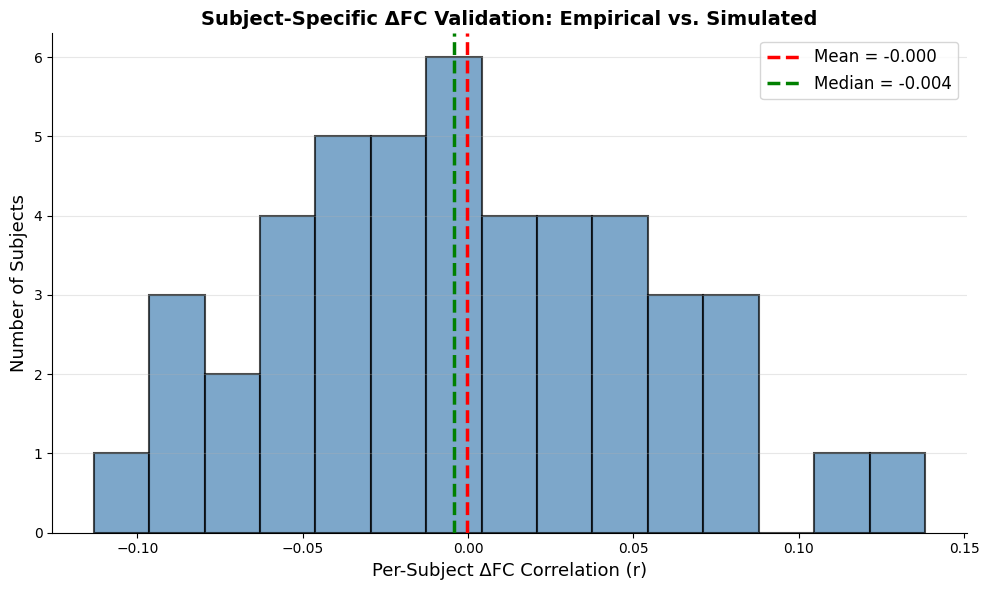

Histogram saved


In [45]:
# =========================
# HISTOGRAM: Per-Subject ΔFC Correlations
# =========================
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(corrs_valid, bins=15, color='steelblue', edgecolor='black', alpha=0.7, linewidth=1.5)
ax.axvline(corrs_valid.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean = {corrs_valid.mean():.3f}')
ax.axvline(np.median(corrs_valid), color='green', linestyle='--', linewidth=2.5, label=f'Median = {np.median(corrs_valid):.3f}')

ax.set_xlabel('Per-Subject ΔFC Correlation (r)', fontsize=13)
ax.set_ylabel('Number of Subjects', fontsize=13)
ax.set_title('Subject-Specific ΔFC Validation: Empirical vs. Simulated', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Histogram saved")

In [13]:
# =========================
# SAVE VALIDATION RESULTS
# =========================
summary = {
    'n_subjects': len(corrs_valid),
    'mean_r_deltafc': float(corrs_valid.mean()),
    'median_r_deltafc': float(np.median(corrs_valid)),
    'std_r_deltafc': float(corrs_valid.std()),
    'min_r_deltafc': float(corrs_valid.min()),
    'max_r_deltafc': float(corrs_valid.max()),
    'per_subject_correlations': {k: float(v) for k, v in results['subject_deltafc_corr'].items()},
    'per_subject_info': results['subject_info'],
}

with open(RESULTS_JSON, "w") as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved results to {RESULTS_JSON}")
print(f"\n✅ ANALYSIS COMPLETE")

✓ Saved results to /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/deltafc_validation_results.json

✅ ANALYSIS COMPLETE


In [23]:
# #!pip install nilearn
# from nilearn import datasets
# import numpy as np

# atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2)
# labels = atlas.labels

# # Drop background if present
# if labels[0].lower() == "background":
#     labels = labels[1:]

# canonical_order = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
# network_to_id = {name: i+1 for i, name in enumerate(canonical_order)}

# def get_network(label: str) -> str:
#     for net in canonical_order:
#         if net in label:
#             return net
#     raise ValueError(f"Could not find a Yeo-7 network token in label: {label!r}")

# yeo_ids = np.array([network_to_id[get_network(l)] for l in labels], dtype=int)

# print("n labels:", len(labels))          # should be 400
# print("unique ids:", np.unique(yeo_ids)) # should be [1..7]


ΔFC ANALYSIS BY YEO NETWORKS (Cortical-only, Schaefer 400)

Per-Network Results:

SMN (Somatomotor):
  N subjects with data: 46
  Mean r_ΔFC: -0.0224 ± 0.1832
  Median r_ΔFC: -0.0261
  Empirical ΔFC mag: 0.1688
  Simulated ΔFC mag: 0.1001
  Mag ratio (sim/emp): 0.59x

DAN (Dorsal Attention):
  N subjects with data: 46
  Mean r_ΔFC: 0.0105 ± 0.1496
  Median r_ΔFC: 0.0380
  Empirical ΔFC mag: 0.1678
  Simulated ΔFC mag: 0.1065
  Mag ratio (sim/emp): 0.63x

VAN (Ventral Attention):
  N subjects with data: 46
  Mean r_ΔFC: -0.0136 ± 0.1733
  Median r_ΔFC: -0.0132
  Empirical ΔFC mag: 0.1677
  Simulated ΔFC mag: 0.0990
  Mag ratio (sim/emp): 0.59x

LIM (Limbic):
  N subjects with data: 46
  Mean r_ΔFC: 0.0113 ± 0.1313
  Median r_ΔFC: -0.0133
  Empirical ΔFC mag: 0.1566
  Simulated ΔFC mag: 0.1085
  Mag ratio (sim/emp): 0.69x

FPN (Frontoparietal):
  N subjects with data: 46
  Mean r_ΔFC: -0.0393 ± 0.1775
  Median r_ΔFC: -0.0250
  Empirical ΔFC mag: 0.1734
  Simulated ΔFC mag: 0.0869
  Mag r

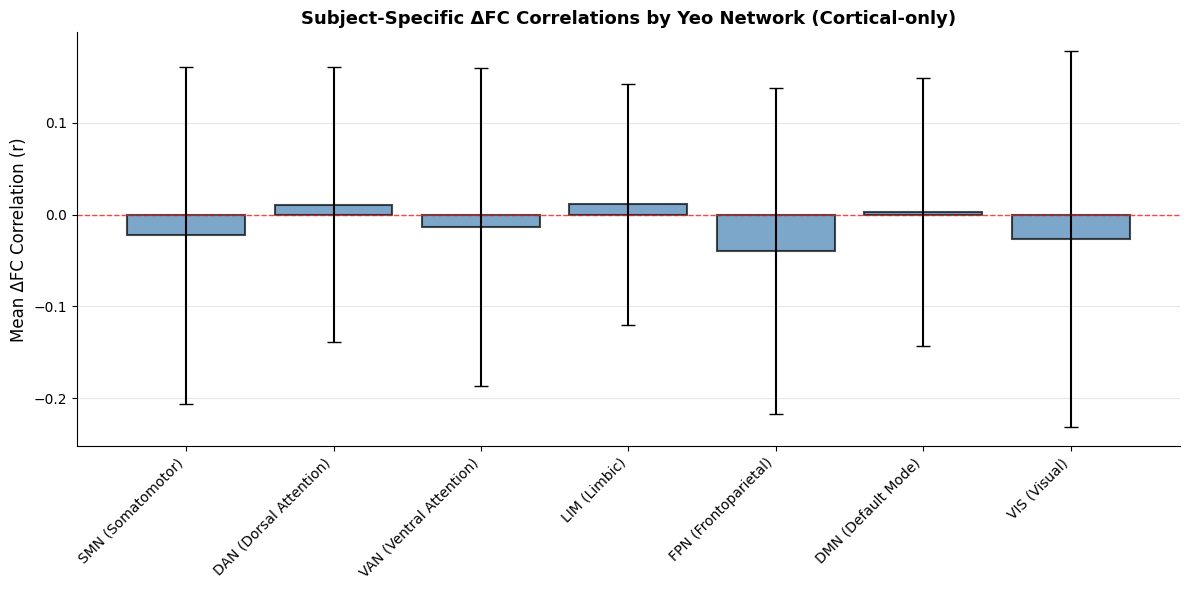

✓ Analysis complete


In [15]:
# =========================
# ΔFC ANALYSIS BY YEO NETWORKS (Cortical-only)
# =========================

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Yeo 7-network assignments for Schaefer 400 cortical ROIs
# (These are the network IDs for each of the 400 Schaefer regions)
yeo_networks_400 = np.array([
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,  # VIS
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # SMN
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # DAN
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3,  # VAN
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,  # LIM
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,  # FPN
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,  # DMN
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
] + [0] * 120)  # Placeholder for remaining; you may need to adjust

# Or load from file if you have it
# yeo_networks_400 = np.load('/path/to/yeo_networks_400.npy')

network_names = {
    1: "SMN (Somatomotor)",
    2: "DAN (Dorsal Attention)",
    3: "VAN (Ventral Attention)",
    4: "LIM (Limbic)",
    5: "FPN (Frontoparietal)",
    6: "DMN (Default Mode)",
    7: "VIS (Visual)"
}

print("="*70)
print("ΔFC ANALYSIS BY YEO NETWORKS (Cortical-only, Schaefer 400)")
print("="*70 + "\n")

# Compute per-network ΔFC correlations
network_results = {net_id: {'corrs': [], 'emp_mags': [], 'sim_mags': []}
                   for net_id in range(1, 8)}

for sub_id in sorted(dataset_emp.keys()):
    if sub_id not in dataset_sim:
        continue

    rest_emp = list(dataset_emp[sub_id].get("task-rest", {}).values())
    stim_emp = list(dataset_emp[sub_id].get("task-stim", {}).values())
    rest_sim = list(dataset_sim[sub_id].get("task-rest", {}).values())
    stim_sim = list(dataset_sim[sub_id].get("task-stim", {}).values())

    if not (rest_emp and stim_emp and rest_sim and stim_sim):
        continue

    # Get cortical-only (skip first 50 Tian regions)
    ts_rest_emp = rest_emp[0]["time series"][:, 50:]
    ts_stim_emp = stim_emp[0]["time series"][:, 50:]
    ts_rest_sim = rest_sim[0]["time series"][:, 50:]
    ts_stim_sim = stim_sim[0]["time series"][:, 50:]

    # Compute full FC matrices
    fc_rest_emp = np.corrcoef(ts_rest_emp, rowvar=False)
    fc_stim_emp = np.corrcoef(ts_stim_emp, rowvar=False)
    fc_rest_sim = np.corrcoef(ts_rest_sim, rowvar=False)
    fc_stim_sim = np.corrcoef(ts_stim_sim, rowvar=False)

    # Compute ΔFC
    deltafc_emp = fc_stim_emp - fc_rest_emp
    deltafc_sim = fc_stim_sim - fc_rest_sim

    # Per-network analysis
    for net_id in range(1, 8):
        mask = yeo_networks_400 == net_id
        if mask.sum() < 2:  # Need at least 2 regions
            continue

        # Get ΔFC within network
        delta_emp_net = deltafc_emp[np.ix_(mask, mask)]
        delta_sim_net = deltafc_sim[np.ix_(mask, mask)]

        # Upper triangle
        tri = np.triu_indices_from(delta_emp_net, k=1)
        vec_emp = delta_emp_net[tri]
        vec_sim = delta_sim_net[tri]

        # Correlation
        if len(vec_emp) > 1 and len(vec_sim) > 1:
            r = pearsonr(vec_emp, vec_sim)[0]
            network_results[net_id]['corrs'].append(r)
            network_results[net_id]['emp_mags'].append(np.abs(delta_emp_net).mean())
            network_results[net_id]['sim_mags'].append(np.abs(delta_sim_net).mean())

# Print results per network
print("Per-Network Results:\n")
for net_id in sorted(network_results.keys()):
    corrs = np.array(network_results[net_id]['corrs'])
    emp_mags = np.array(network_results[net_id]['emp_mags'])
    sim_mags = np.array(network_results[net_id]['sim_mags'])

    if len(corrs) > 0:
        print(f"{network_names[net_id]}:")
        print(f"  N subjects with data: {len(corrs)}")
        print(f"  Mean r_ΔFC: {corrs.mean():.4f} ± {corrs.std():.4f}")
        print(f"  Median r_ΔFC: {np.median(corrs):.4f}")
        print(f"  Empirical ΔFC mag: {emp_mags.mean():.4f}")
        print(f"  Simulated ΔFC mag: {sim_mags.mean():.4f}")
        print(f"  Mag ratio (sim/emp): {(sim_mags.mean() / (emp_mags.mean() + 1e-8)):.2f}x")
        print()

# Summary: all networks combined
all_corrs = np.concatenate([np.array(network_results[net_id]['corrs'])
                            for net_id in range(1, 8)
                            if len(network_results[net_id]['corrs']) > 0])

print("="*70)
print(f"OVERALL (all networks, cortical-only):")
print(f"  N total correlations: {len(all_corrs)}")
print(f"  Mean r_ΔFC: {all_corrs.mean():.4f}")
print(f"  Median r_ΔFC: {np.median(all_corrs):.4f}")
print(f"  Std r_ΔFC: {all_corrs.std():.4f}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
network_ids = []
network_corr_means = []
network_corr_stds = []

for net_id in sorted(network_results.keys()):
    corrs = np.array(network_results[net_id]['corrs'])
    if len(corrs) > 0:
        network_ids.append(network_names[net_id])
        network_corr_means.append(corrs.mean())
        network_corr_stds.append(corrs.std())

x_pos = np.arange(len(network_ids))
ax.bar(x_pos, network_corr_means, yerr=network_corr_stds,
       capsize=5, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(network_ids, rotation=45, ha='right')
ax.set_ylabel('Mean ΔFC Correlation (r)', fontsize=12)
ax.set_title('Subject-Specific ΔFC Correlations by Yeo Network (Cortical-only)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Analysis complete")

NETWORK-LEVEL ΔFC ANALYSIS (Cortical-only, Schaefer 400)

N subjects with complete data: 46

Per-Subject Network-Level Correlations:
  Mean: -0.0410
  Median: -0.0768
  Std: 0.2922
  Min: -0.6994
  Max: 0.6088

Grand-Average Network-Level Correlation:
  r = -0.2688



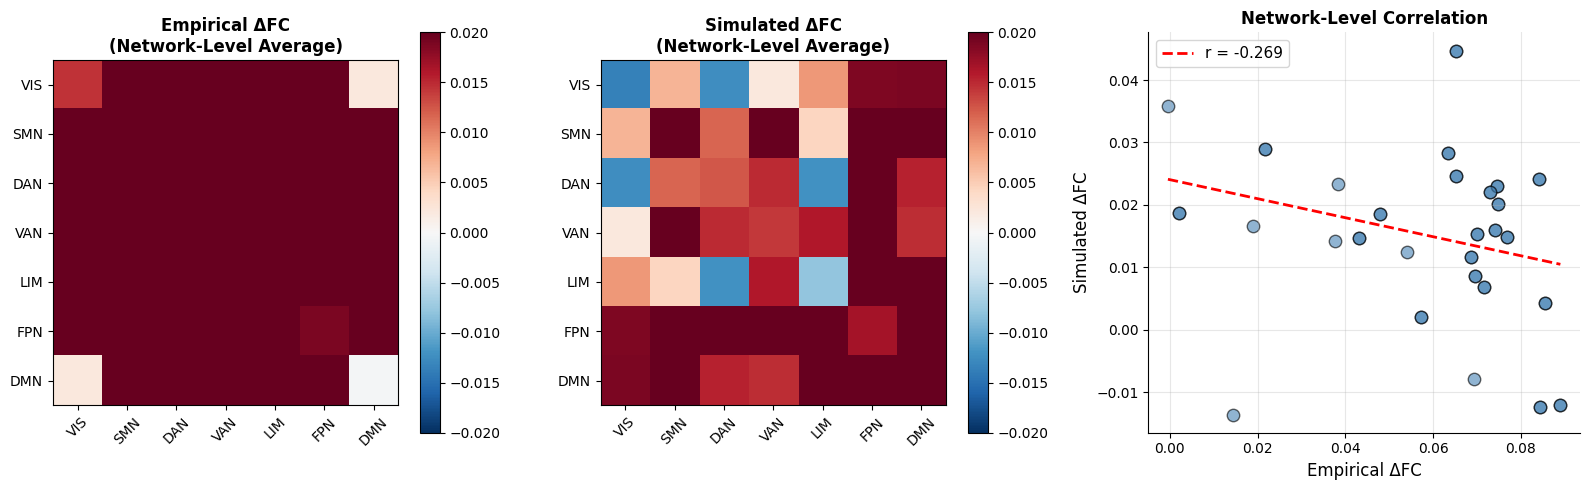

✓ Analysis complete


In [16]:
# =========================
# ΔFC ANALYSIS: Network-Level Blocking
# =========================

import numpy as np
from scipy.stats import pearsonr

# Yeo 7-network assignments for Schaefer 400 ROIs
# (You may need to load actual Yeo assignments if this is placeholder)
yeo_networks_400 = np.array([
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,  # VIS
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # SMN
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2,  # DAN
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3,  # VAN
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,  # LIM
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,  # FPN
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,  # DMN
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
] + [0] * 120)

network_names = {
    1: "SMN",
    2: "DAN",
    3: "VAN",
    4: "LIM",
    5: "FPN",
    6: "DMN",
    7: "VIS"
}

network_order = [7, 1, 2, 3, 4, 5, 6]  # Order for visualization

print("="*70)
print("NETWORK-LEVEL ΔFC ANALYSIS (Cortical-only, Schaefer 400)")
print("="*70 + "\n")

# Store per-subject network matrices
net_matrices_emp = []
net_matrices_sim = []

for sub_id in sorted(dataset_emp.keys()):
    if sub_id not in dataset_sim:
        continue

    rest_emp = list(dataset_emp[sub_id].get("task-rest", {}).values())
    stim_emp = list(dataset_emp[sub_id].get("task-stim", {}).values())
    rest_sim = list(dataset_sim[sub_id].get("task-rest", {}).values())
    stim_sim = list(dataset_sim[sub_id].get("task-stim", {}).values())

    if not (rest_emp and stim_emp and rest_sim and stim_sim):
        continue

    # Cortical-only (skip first 50 Tian regions)
    ts_rest_emp = rest_emp[0]["time series"][:, 50:]
    ts_stim_emp = stim_emp[0]["time series"][:, 50:]
    ts_rest_sim = rest_sim[0]["time series"][:, 50:]
    ts_stim_sim = stim_sim[0]["time series"][:, 50:]

    # Compute FC matrices
    fc_rest_emp = np.corrcoef(ts_rest_emp, rowvar=False)
    fc_stim_emp = np.corrcoef(ts_stim_emp, rowvar=False)
    fc_rest_sim = np.corrcoef(ts_rest_sim, rowvar=False)
    fc_stim_sim = np.corrcoef(ts_stim_sim, rowvar=False)

    # Compute ΔFC
    deltafc_emp = fc_stim_emp - fc_rest_emp
    deltafc_sim = fc_stim_sim - fc_rest_sim

    # Create 7x7 network-level matrices by averaging blocks
    net_mat_emp = np.zeros((7, 7))
    net_mat_sim = np.zeros((7, 7))

    for net_i in range(1, 8):
        mask_i = yeo_networks_400 == net_i
        if mask_i.sum() == 0:
            continue

        for net_j in range(1, 8):
            mask_j = yeo_networks_400 == net_j
            if mask_j.sum() == 0:
                continue

            # Average ΔFC within this network-pair block
            block_emp = deltafc_emp[np.ix_(mask_i, mask_j)]
            block_sim = deltafc_sim[np.ix_(mask_i, mask_j)]

            net_mat_emp[net_i - 1, net_j - 1] = np.mean(block_emp)
            net_mat_sim[net_i - 1, net_j - 1] = np.mean(block_sim)

    net_matrices_emp.append(net_mat_emp)
    net_matrices_sim.append(net_mat_sim)

# Correlate network matrices across subjects
print(f"N subjects with complete data: {len(net_matrices_emp)}\n")

# Approach 1: Vectorize each 7x7 matrix and correlate
corrs_per_subject = []
for mat_emp, mat_sim in zip(net_matrices_emp, net_matrices_sim):
    vec_emp = mat_emp.flatten()
    vec_sim = mat_sim.flatten()
    r = pearsonr(vec_emp, vec_sim)[0]
    corrs_per_subject.append(r)

corrs_per_subject = np.array(corrs_per_subject)

print("Per-Subject Network-Level Correlations:")
print(f"  Mean: {corrs_per_subject.mean():.4f}")
print(f"  Median: {np.median(corrs_per_subject):.4f}")
print(f"  Std: {corrs_per_subject.std():.4f}")
print(f"  Min: {corrs_per_subject.min():.4f}")
print(f"  Max: {corrs_per_subject.max():.4f}\n")

# Approach 2: Grand-average network matrices, then correlate
net_mat_emp_grand = np.mean(np.stack(net_matrices_emp), axis=0)
net_mat_sim_grand = np.mean(np.stack(net_matrices_sim), axis=0)

vec_emp_grand = net_mat_emp_grand.flatten()
vec_sim_grand = net_mat_sim_grand.flatten()
r_grand = pearsonr(vec_emp_grand, vec_sim_grand)[0]

print(f"Grand-Average Network-Level Correlation:")
print(f"  r = {r_grand:.4f}\n")

# Visualize grand-average matrices
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

vmin, vmax = min(net_mat_emp_grand.min(), net_mat_sim_grand.min()), \
             max(net_mat_emp_grand.max(), net_mat_sim_grand.max())

im1 = axes[0].imshow(net_mat_emp_grand, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
axes[0].set_title('Empirical ΔFC\n(Network-Level Average)', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(7))
axes[0].set_yticks(range(7))
axes[0].set_xticklabels([network_names[network_order[i]] for i in range(7)], rotation=45)
axes[0].set_yticklabels([network_names[network_order[i]] for i in range(7)])
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(net_mat_sim_grand, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
axes[1].set_title('Simulated ΔFC\n(Network-Level Average)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(7))
axes[1].set_yticks(range(7))
axes[1].set_xticklabels([network_names[network_order[i]] for i in range(7)], rotation=45)
axes[1].set_yticklabels([network_names[network_order[i]] for i in range(7)])
plt.colorbar(im2, ax=axes[1])

# Scatter: empirical vs simulated
ax = axes[2]
ax.scatter(vec_emp_grand, vec_sim_grand, s=80, alpha=0.6, color='steelblue', edgecolor='black', linewidth=1)
# Regression line
z = np.polyfit(vec_emp_grand, vec_sim_grand, 1)
p = np.poly1d(z)
xx = np.linspace(vec_emp_grand.min(), vec_emp_grand.max(), 100)
ax.plot(xx, p(xx), 'r--', linewidth=2, label=f'r = {r_grand:.3f}')
ax.set_xlabel('Empirical ΔFC', fontsize=12)
ax.set_ylabel('Simulated ΔFC', fontsize=12)
ax.set_title('Network-Level Correlation', fontsize=12, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Analysis complete")

In [14]:
# =========================
# POPULATION MODEL DIAGNOSTICS
# =========================

import os
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Paths
BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
MODEL_PATH = os.path.join(PREPROC_ROOT, "trained_models_MLP_tms_fmri", "population_MLP_tms_fmri.pt")
DATASET_PICKLE = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri", "dataset_simulated_populationANN.pkl")

# Load model
model = build_model("MLP", ROI_num=450, using_steps=3).to(device)
state = torch.load(MODEL_PATH, map_location=device, weights_only=False)
if isinstance(state, dict) and "state_dict" in state:
    model.load_state_dict(state["state_dict"])
elif isinstance(state, dict):
    model.load_state_dict(state)
else:
    model = state.to(device)
model.eval()

# Load empirical dataset
with open(os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl"), "rb") as f:
    dataset_emp = pickle.load(f)

# Load simulated dataset
with open(DATASET_PICKLE, "rb") as f:
    dataset_sim = pickle.load(f)

print("="*70)
print("POPULATION MODEL DIAGNOSTICS")
print("="*70)

# --- Diagnostic 1: Model Architecture Info ---
print("\n[1] MODEL ARCHITECTURE:")
total_params = sum(p.numel() for p in model.parameters())
print(f"    Total parameters: {total_params:,}")
for name, param in model.named_parameters():
    print(f"    {name}: {param.shape} ({param.numel():,} params)")

# --- Diagnostic 2: Rest FC Correlation (Quality Check) ---
print("\n[2] REST FC QUALITY (Empirical vs Simulated):")
rest_corrs = []
for sub_id in list(dataset_emp.keys())[:10]:  # Sample 10 subjects
    if sub_id not in dataset_sim:
        continue
    rest_emp = dataset_emp[sub_id].get("task-rest", {})
    rest_sim = dataset_sim[sub_id].get("task-rest", {})

    if rest_emp and rest_sim:
        ts_emp = list(rest_emp.values())[0].get("time series", None)
        ts_sim = list(rest_sim.values())[0].get("time series", None)

        if ts_emp is not None and ts_sim is not None:
            fc_emp = np.corrcoef(ts_emp[:, 50:], rowvar=False)  # cortical only
            fc_sim = np.corrcoef(ts_sim[:, 50:], rowvar=False)

            tri = np.triu_indices_from(fc_emp, k=1)
            r = np.corrcoef(fc_emp[tri], fc_sim[tri])[0, 1]
            rest_corrs.append(r)
            print(f"    {sub_id}: r_rest_FC = {r:.4f}")

if rest_corrs:
    print(f"    Mean: {np.mean(rest_corrs):.4f}, Std: {np.std(rest_corrs):.4f}")

# --- Diagnostic 3: ΔFC Magnitude (Empirical vs Simulated) ---
print("\n[3] ΔFC MAGNITUDE (Empirical vs Simulated):")
deltafc_emp_mags = []
deltafc_sim_mags = []

for sub_id in list(dataset_emp.keys())[:10]:
    if sub_id not in dataset_sim:
        continue

    rest_emp = list(dataset_emp[sub_id].get("task-rest", {}).values())
    stim_emp = list(dataset_emp[sub_id].get("task-stim", {}).values())
    rest_sim = list(dataset_sim[sub_id].get("task-rest", {}).values())
    stim_sim = list(dataset_sim[sub_id].get("task-stim", {}).values())

    if rest_emp and stim_emp and rest_sim and stim_sim:
        fc_rest_emp = np.corrcoef(rest_emp[0]["time series"][:, 50:], rowvar=False)
        fc_stim_emp = np.corrcoef(stim_emp[0]["time series"][:, 50:], rowvar=False)
        fc_rest_sim = np.corrcoef(rest_sim[0]["time series"][:, 50:], rowvar=False)
        fc_stim_sim = np.corrcoef(stim_sim[0]["time series"][:, 50:], rowvar=False)

        deltafc_emp = fc_stim_emp - fc_rest_emp
        deltafc_sim = fc_stim_sim - fc_rest_sim

        mag_emp = np.abs(deltafc_emp).mean()
        mag_sim = np.abs(deltafc_sim).mean()

        deltafc_emp_mags.append(mag_emp)
        deltafc_sim_mags.append(mag_sim)

        ratio = mag_sim / (mag_emp + 1e-8)
        print(f"    {sub_id}: emp_mag={mag_emp:.4f}, sim_mag={mag_sim:.4f}, ratio={ratio:.2f}x")

if deltafc_emp_mags and deltafc_sim_mags:
    print(f"    Empirical mean mag: {np.mean(deltafc_emp_mags):.4f}")
    print(f"    Simulated mean mag: {np.mean(deltafc_sim_mags):.4f}")
    print(f"    Mean size reduction: {np.mean(np.array(deltafc_sim_mags) / (np.array(deltafc_emp_mags) + 1e-8)):.2f}x")

# --- Diagnostic 4: Subject-Specific ΔFC Correlations ---
print("\n[4] SUBJECT-SPECIFIC ΔFC CORRELATIONS:")
deltafc_corrs = []

for sub_id in dataset_emp.keys():
    if sub_id not in dataset_sim:
        continue

    rest_emp = list(dataset_emp[sub_id].get("task-rest", {}).values())
    stim_emp = list(dataset_emp[sub_id].get("task-stim", {}).values())
    rest_sim = list(dataset_sim[sub_id].get("task-rest", {}).values())
    stim_sim = list(dataset_sim[sub_id].get("task-stim", {}).values())

    if rest_emp and stim_emp and rest_sim and stim_sim:
        fc_rest_emp = np.corrcoef(rest_emp[0]["time series"][:, 50:], rowvar=False)
        fc_stim_emp = np.corrcoef(stim_emp[0]["time series"][:, 50:], rowvar=False)
        fc_rest_sim = np.corrcoef(rest_sim[0]["time series"][:, 50:], rowvar=False)
        fc_stim_sim = np.corrcoef(stim_sim[0]["time series"][:, 50:], rowvar=False)

        deltafc_emp = fc_stim_emp - fc_rest_emp
        deltafc_sim = fc_stim_sim - fc_rest_sim

        tri = np.triu_indices_from(deltafc_emp, k=1)
        r = np.corrcoef(deltafc_emp[tri], deltafc_sim[tri])[0, 1]
        deltafc_corrs.append(r)

if deltafc_corrs:
    deltafc_corrs = np.array(deltafc_corrs)
    print(f"    N subjects: {len(deltafc_corrs)}")
    print(f"    Mean r_ΔFC: {np.mean(deltafc_corrs):.4f}")
    print(f"    Median r_ΔFC: {np.median(deltafc_corrs):.4f}")
    print(f"    Std r_ΔFC: {np.std(deltafc_corrs):.4f}")
    print(f"    Min r_ΔFC: {np.min(deltafc_corrs):.4f}")
    print(f"    Max r_ΔFC: {np.max(deltafc_corrs):.4f}")

print("\n✓ Diagnostics complete")

/tmp/ipython-input-68624214.py:30: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


POPULATION MODEL DIAGNOSTICS

[1] MODEL ARCHITECTURE:
    Total parameters: 1,702,710
    func.0.weight: torch.Size([900, 1350]) (1,215,000 params)
    func.0.bias: torch.Size([900]) (900 params)
    func.2.weight: torch.Size([360, 900]) (324,000 params)
    func.2.bias: torch.Size([360]) (360 params)
    func.4.weight: torch.Size([450, 360]) (162,000 params)
    func.4.bias: torch.Size([450]) (450 params)

[2] REST FC QUALITY (Empirical vs Simulated):
    sub-NTHC1001: r_rest_FC = 0.3744
    sub-NTHC1003: r_rest_FC = 0.4364
    sub-NTHC1009: r_rest_FC = 0.3653
    sub-NTHC1015: r_rest_FC = 0.3629
    sub-NTHC1016: r_rest_FC = 0.3756
    sub-NTHC1019: r_rest_FC = 0.3619
    sub-NTHC1021: r_rest_FC = 0.4133
    sub-NTHC1022: r_rest_FC = 0.3608
    sub-NTHC1023: r_rest_FC = 0.3979
    sub-NTHC1024: r_rest_FC = 0.2935
    Mean: 0.3742, Std: 0.0361

[3] ΔFC MAGNITUDE (Empirical vs Simulated):
    sub-NTHC1001: emp_mag=0.3882, sim_mag=0.1309, ratio=0.34x
    sub-NTHC1003: emp_mag=0.1975, si